In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Define functions for pruning

In [2]:
# app = track_info['appearances']
def get_real_dict(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]

    real_dict = dict.fromkeys(range(batches))
    for batch in range(batches):
        real_dict[batch] = {}

    # Gets number of real cells in each batch
    for batch in range(batches):
        for cell in range(cells):
            if np.max(app[batch, 0, cell]) != 0:
                last_frame = 71
                for frame in range(frames):
                    if np.max(app[batch, frame, cell]) == 0:
                        last_frame = frame
                        break
                real_dict[batch][cell] = last_frame
            else:
                break
    return real_dict

In [8]:
def get_real_img_array(app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    real_img_list = []
    real_dict = get_real_dict(app)
    for batch in range(batches):
        for cell in real_dict[batch].keys():
            for frame in range(real_dict[batch][cell]):
                real_img_list.append(app[batch][frame][cell])
    appearances = np.array(real_img_list)
    return appearances

In [2]:
import json
def load_img_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k1): {int(k2): {int(k3): v for k3, v in d[k1][k2].items()} for k2, d[k1][k2] in d[k1].items()} for k1, d[k1] in d.items()}
    return d
def load_img_idx_dict(file):
    f = open(file)
    d = json.load(f)
    d = {int(k): v for k, v in d.items()}
    return d

In [3]:
train_good_imgs = load_img_dict('../dataset_pruning/train_appearances_dict.json')
train_blank_imgs = load_img_dict('../dataset_pruning/train_blank_dict.json')
train_border_imgs = load_img_dict('../dataset_pruning/train_border_dict.json')
val_good_imgs = load_img_dict('../dataset_pruning/val_appearances_dict.json')
val_blank_imgs = load_img_dict('../dataset_pruning/val_blank_dict.json')
val_border_imgs = load_img_dict('../dataset_pruning/val_border_dict.json')

FileNotFoundError: [Errno 2] No such file or directory: '../dataset_pruning/train_appearances_dict.json'

In [11]:
def get_good_img_arr(good_imgs, app):
    batches = app.shape[0]
    frames = app.shape[1]
    cells = app.shape[2]
    
    good_img_list = []
    for batch in range(batches):
        for cell in range(cells):
            for frame in range(frames):
                if good_imgs[batch][cell][frame] != -1:
                    good_img_list.append(app[batch][frame][cell])
    appearances = np.array(good_img_list)
    return appearances

In [9]:
from skimage.exposure import rescale_intensity

def norm(X):
    X_norm = histogram_normalization(X, kernel_size=32)
    
    X_rescaled = np.zeros(X_norm.shape)
    for img_idx in range(X.shape[0]):
        x = X[img_idx]
        x = rescale_intensity(x, out_range=(0,1))
        X_rescaled[img_idx] = x
            
    return X_rescaled

In [10]:
def prepare_dataset(appearances, batch_size=1, buffer_size=256,
                    seed=None):
    app_shape = np.shape(appearances)

    # Appearances not being normalized yet (will have to slightly modify norm function
    # since we don't have this organized by life cycle
    appearances = norm(appearances)

    dataset = tf.data.Dataset.from_tensor_slices((appearances, appearances))
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Load the train data

In [7]:
%%time
# data loading
# Need crop_mode='fixed' param in Track in real life
with tf.device('/device:CPU:0'):
    path_temp_train_trks = '/training/tracking-nuclear/train.trks'
    all_train_data = [load_trks(path_temp_train_trks)]
    
    all_train_tracks = [Track(tracked_data=d, crop_mode='fixed') for d in all_train_data]
    
    train_track_info = concat_tracks(all_train_tracks)
    
    train_appearances = get_real_img_array(train_track_info['appearances'])
    
    train_dataset = prepare_dataset(train_appearances, batch_size=100)

2022-07-26 00:14:07.278970: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 00:14:08.048198: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5053 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
 33%|██████████████▏                            | 30/91 [05:15<11:49, 11.63s/it]/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / r

NameError: name 'get_real_img_nums_dict' is not defined

In [12]:
with tf.device('/device:CPU:0'):
    train_appearances = get_real_img_array(train_track_info['appearances'])
    
    train_dataset = prepare_dataset(train_appearances, batch_size=100)

# Load the validation data

In [12]:
%%time
with tf.device('/device:CPU:0'):
    path_temp_val_trks = '/training/tracking-nuclear/val.trks'
    all_val_data = [load_trks(path_temp_val_trks)]
    print("All " + str(len(all_val_data)) + " trks are loaded")
    
    all_val_tracks = [Track(tracked_data=d, appearance_dim=64, crop_mode='fixed') for d in all_val_data]
    print("converted to Track objects")
    
    val_track_info = concat_tracks(all_val_tracks)

2022-08-08 22:02:47.642294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-08 22:02:49.460847: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9130 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


All 1 trks are loaded


100%|███████████████████████████████████████████| 27/27 [03:38<00:00,  8.08s/it]


converted to Track objects
CPU times: user 21min 17s, sys: 26min 35s, total: 47min 53s
Wall time: 8min 37s


In [14]:
with tf.device('/device:CPU:0'):
    val_good_img_arr = get_good_img_arr(val_good_imgs, val_track_info['appearances'])
    
    train_dataset = prepare_dataset(val_good_img_arr, batch_size=1)

2022-08-08 22:20:10.851929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2930638848 exceeds 10% of free system memory.
2022-08-08 22:20:12.799486: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2930638848 exceeds 10% of free system memory.


In [ ]:
# misnamed it train_dataset

In [16]:
for sample in train_dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

2022-08-08 22:21:03.163984: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2930638848 exceeds 10% of free system memory.


(1, 64, 64, 1)
(1, 64, 64, 1)


# Define the model

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [10]:
class VAE_MNIST:
    
    def __init__(self, dim_z, kl_weight, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [10]:
vae = VAE_MNIST(512, 1, 1e-3)
AE = vae.build_vae_keras_model()

2022-07-22 20:09:26.626516: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [11]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_512_full_reg'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

2022-07-22 20:10:48.647280: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734923776 exceeds 10% of free system memory.
2022-07-22 20:10:49.864048: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2734923776 exceeds 10% of free system memory.


Epoch 1/15


2022-07-22 20:10:54.150726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3338/3339 [============================>.] - ETA: 0s - loss: -972.6938
Epoch 1: val_loss improved from inf to -1153.44543, saving model to ../models/dim_512_full_reg
3339/3339 [==============================] - 46s 12ms/step - loss: -972.5956 - val_loss: -1153.4454 - lr: 0.0010
Epoch 2/15
3338/3339 [============================>.] - ETA: 0s - loss: -1246.1626
Epoch 2: val_loss did not improve from -1153.44543
3339/3339 [==============================] - 38s 11ms/step - loss: -1245.9585 - val_loss: -1010.4239 - lr: 0.0010
Epoch 3/15
3338/3339 [============================>.] - ETA: 0s - loss: -1435.0525
Epoch 3: val_loss improved from -1153.44543 to -1303.05237, saving model to ../models/dim_512_full_reg
3339/3339 [==============================] - 39s 12ms/step - loss: -1434.8169 - val_loss: -1303.0524 - lr: 0.0010
Epoch 4/15
3338/3339 [============================>.] - ETA: 0s - loss: -1478.8097
Epoch 4: val_loss did not improve from -1303.05237
3339/3339 [============================

In [12]:
train_appearances.shape

(333853, 32, 32, 1)

In [13]:
val_appearances.shape

(78352, 32, 32, 1)

In [17]:
import random
recon_sample = [263403, 234088, 108714, 100465, 187225, 196221, 132592, 287101, 271923, 184110]

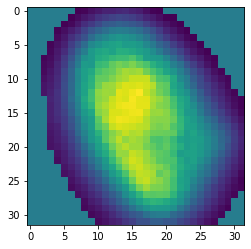

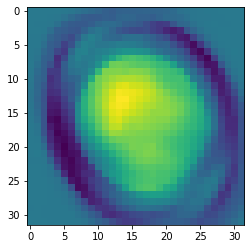

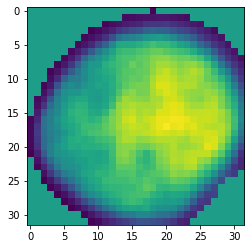

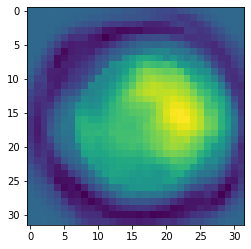

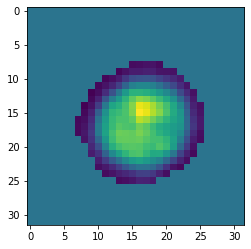

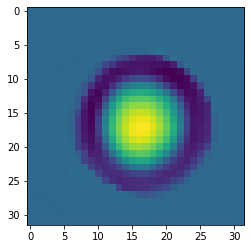

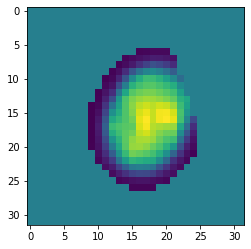

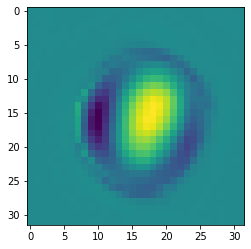

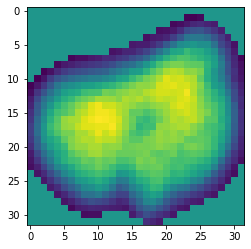

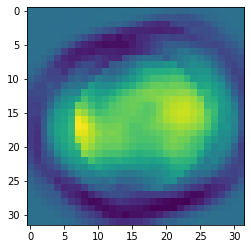

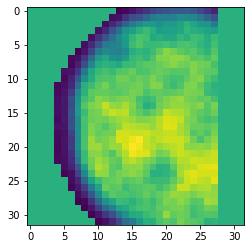

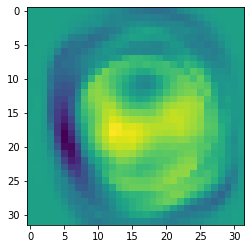

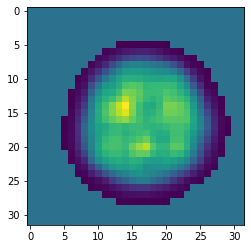

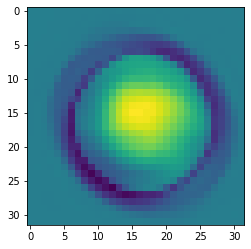

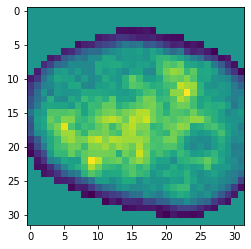

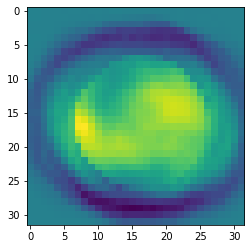

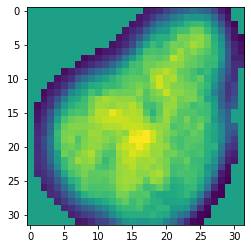

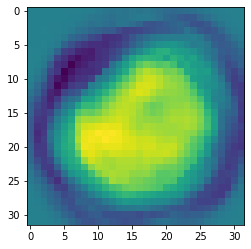

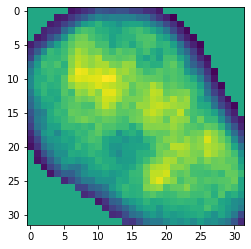

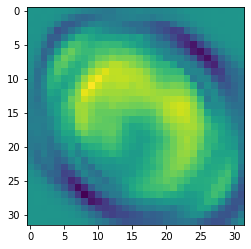

In [18]:
import matplotlib.pyplot as plt

for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [19]:
# Try it with less reguralization

In [20]:
vae2 = VAE_MNIST(512, 0.3, 1e-3)
AE2 = vae2.build_vae_keras_model()

In [21]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/reg_less'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE2.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3335/3339 [============================>.] - ETA: 0s - loss: -822.0765
Epoch 1: val_loss improved from inf to -1025.39636, saving model to ../models/reg_less
3339/3339 [==============================] - 42s 12ms/step - loss: -822.0052 - val_loss: -1025.3964 - lr: 0.0010
Epoch 2/15
3339/3339 [==============================] - ETA: 0s - loss: -1345.0474
Epoch 2: val_loss improved from -1025.39636 to -1263.17322, saving model to ../models/reg_less
3339/3339 [==============================] - 39s 12ms/step - loss: -1345.0474 - val_loss: -1263.1732 - lr: 0.0010
Epoch 3/15
3338/3339 [============================>.] - ETA: 0s - loss: -1341.0782
Epoch 3: val_loss improved from -1263.17322 to -1309.34106, saving model to ../models/reg_less
3339/3339 [==============================] - 40s 12ms/step - loss: -1340.8785 - val_loss: -1309.3411 - lr: 0.0010
Epoch 4/15
3335/3339 [============================>.] - ETA: 0s - loss: -1427.6488
Epoch 4: val_loss improved from -1309.34106 to -159

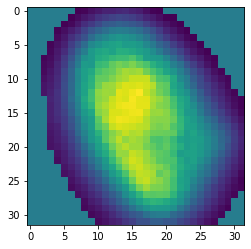

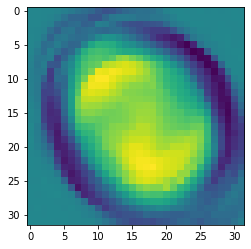

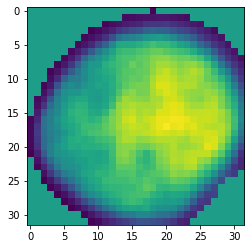

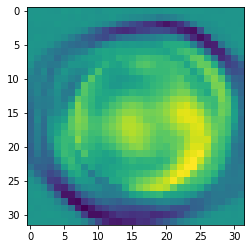

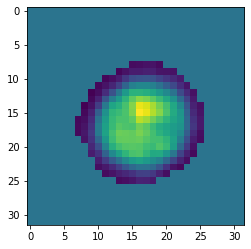

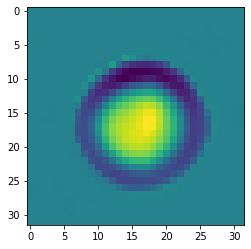

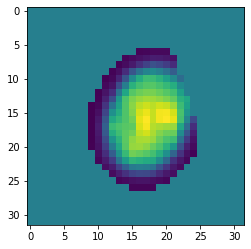

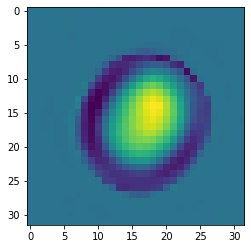

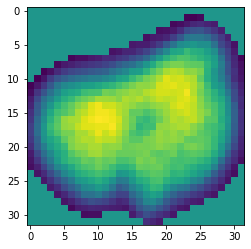

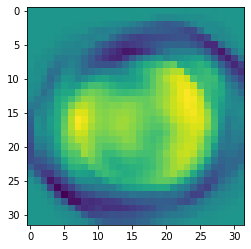

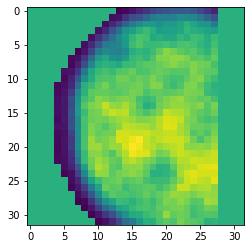

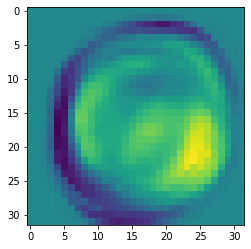

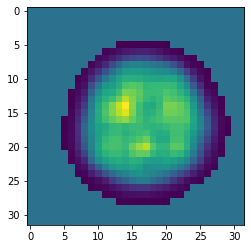

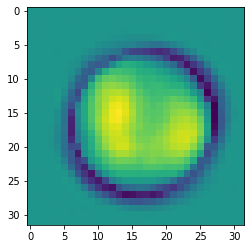

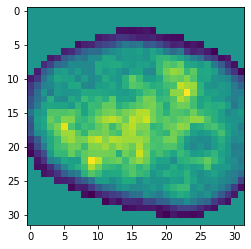

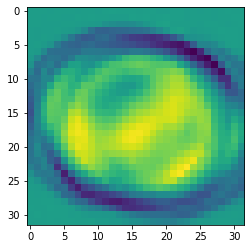

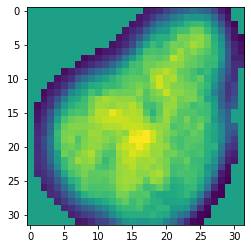

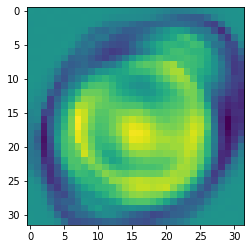

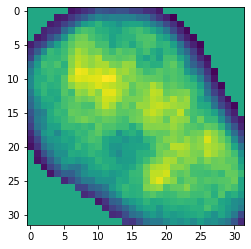

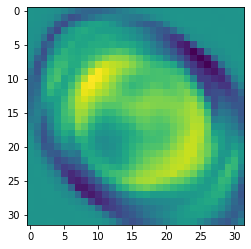

In [22]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE2(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [23]:
# Try with big embedding dim (1024)

In [24]:
vae3 = VAE_MNIST(1024, 1, 1e-3)
AE3 = vae3.build_vae_keras_model()

In [25]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_1024_full_reg'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE3.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3335/3339 [============================>.] - ETA: 0s - loss: -1017.9716
Epoch 1: val_loss improved from inf to -870.84644, saving model to ../models/dim_1024_full_reg
3339/3339 [==============================] - 43s 12ms/step - loss: -1017.5799 - val_loss: -870.8464 - lr: 0.0010
Epoch 2/15
3337/3339 [============================>.] - ETA: 0s - loss: -1466.4492
Epoch 2: val_loss improved from -870.84644 to -1224.30139, saving model to ../models/dim_1024_full_reg
3339/3339 [==============================] - 41s 12ms/step - loss: -1466.0262 - val_loss: -1224.3014 - lr: 0.0010
Epoch 3/15
3339/3339 [==============================] - ETA: 0s - loss: -1595.1993
Epoch 3: val_loss improved from -1224.30139 to -1477.44629, saving model to ../models/dim_1024_full_reg
3339/3339 [==============================] - 40s 12ms/step - loss: -1595.1993 - val_loss: -1477.4463 - lr: 0.0010
Epoch 4/15
3339/3339 [==============================] - ETA: 0s - loss: -1508.7986
Epoch 4: val_loss improve

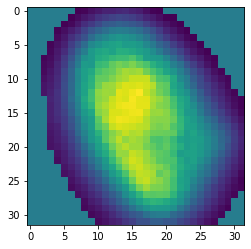

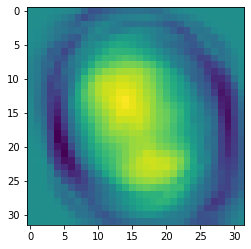

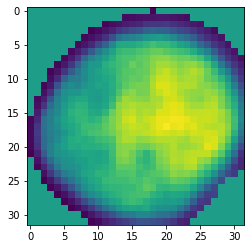

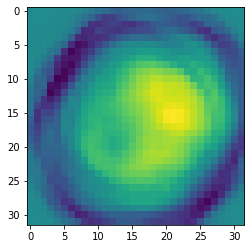

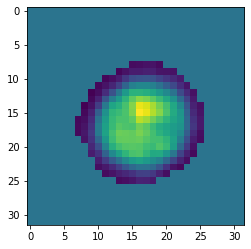

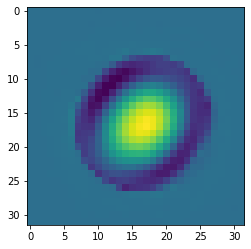

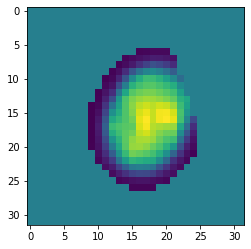

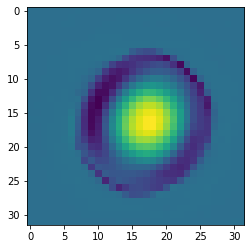

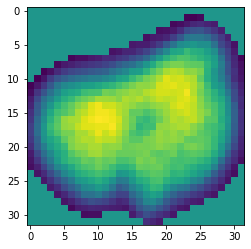

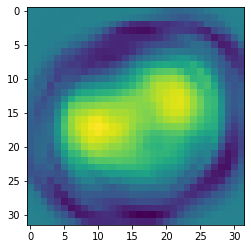

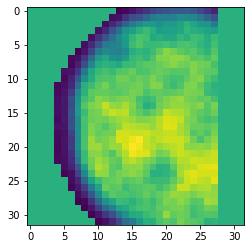

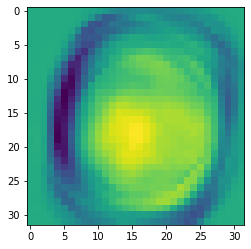

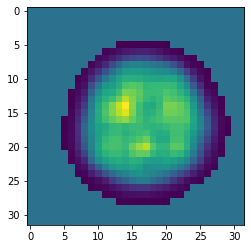

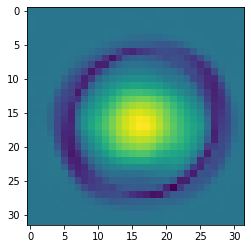

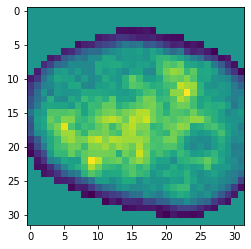

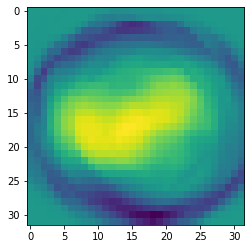

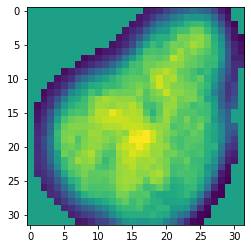

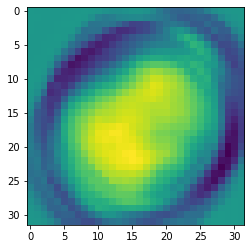

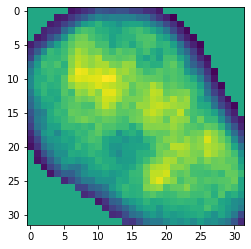

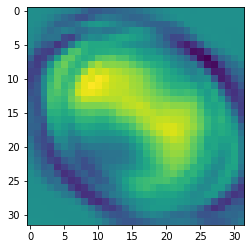

In [26]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE3(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [55]:
import pandas as pd
from keras import backend as K

def get_embedding_distr(img, encoder):
    z_params = encoder.get_layer('z_params')
    inp = encoder.input
    out = z_params.output
    func = K.function([inp], [out])
    x = np.array([img])
    z = func([x])
    return z[0][0]

# Gets embeddings of each array (train, val) along with frame classes
def get_embeddings_df(app, encoder, embedding_dim, real_dict):
    frame_dict = get_frame_dict(app, real_dict)
    
    embeddings_lst = []
    for idx in range(app.shape[0]):
        if idx % 1000 == 0:
            print(idx)
        img = app[idx]
        embedding_distr = get_embedding_distr(img, encoder)
        frame = frame_dict[idx]
        embeddings_lst.append(np.append(embedding_distr, frame))
    
    cols = [idx for idx in range(2 * embedding_dim)]
    cols.append('Frame')
    embeddings_df = pd.DataFrame(embeddings_lst, columns=cols)
    return embeddings_df

In [53]:
def get_original_pos(real_idx, real_dict):
    img_num = real_idx + 1
    batch = 0
    cell = 0
    frame = 0
    
    imgs_seen = 0
    for b in real_dict.keys():
        imgs_will_see = imgs_seen + sum(real_dict[b].values())
        if imgs_will_see >= img_num:
            batch = b
            break
        else:
            imgs_seen = imgs_will_see
    for c in real_dict[batch].keys():
        imgs_will_see = imgs_seen + real_dict[batch][c]
        if imgs_will_see >= img_num:
            cell = c
            break
        else:
            imgs_seen = imgs_will_see
    imgs_left = img_num - imgs_seen
    frame = imgs_left - 1
    
    return (batch, cell, frame)

# Gets dictionary where keys are image indices and values are frames corresponding with image for train_appearances
# or val_appearances arrays
def get_frame_dict(app, real_dict):
    frame_dict = {}
    for idx in range(app.shape[0]):
        frame_dict[idx] = get_original_pos(idx, real_dict)[2]
    return frame_dict

In [48]:
train_real_dict = get_real_dict(train_track_info['appearances'])

In [49]:
encoder3 = vae3.encoder_z()

In [57]:
embeddings_df3 = get_embeddings_df(train_appearances, encoder3, 1024, train_real_dict)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [58]:
def project_embeddings_tsne(embeddings_df, tsne):
    just_embeddings_df = embeddings_df.drop('Frame', axis=1)
    neighbors_embeddings = tsne.fit_transform(just_embeddings_df)
    neighbors_df = pd.DataFrame(data = neighbors_embeddings, columns = ['component 1', 'component 2'])
    
    final_df = pd.concat([neighbors_df, embeddings_df[['Frame']]], axis = 1)
                          
    return final_df

In [59]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

In [64]:
%%time
embeddings_tsne_df3 = project_embeddings_tsne(embeddings_df3, tsne)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 11h 9min 2s, sys: 1min 6s, total: 11h 10min 8s
Wall time: 42min 52s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


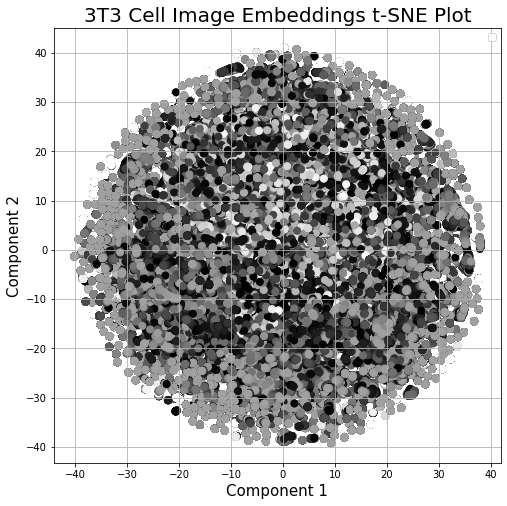

In [66]:
import matplotlib.pyplot as plt

colors = []
for time in embeddings_tsne_df3['Frame']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(embeddings_tsne_df3['component 1'], embeddings_tsne_df3['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [67]:
vae4 = VAE_MNIST(64, 0.1, 1e-3)
AE4 = vae.build_vae_keras_model()

In [68]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_64_reg_1'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE4.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3336/3339 [============================>.] - ETA: 0s - loss: -1054.8229
Epoch 1: val_loss improved from inf to -1080.17163, saving model to ../models/dim_64_reg_1
3339/3339 [==============================] - 41s 12ms/step - loss: -1054.5858 - val_loss: -1080.1716 - lr: 0.0010
Epoch 2/15
3335/3339 [============================>.] - ETA: 0s - loss: -1340.7804
Epoch 2: val_loss improved from -1080.17163 to -1260.74976, saving model to ../models/dim_64_reg_1
3339/3339 [==============================] - 38s 11ms/step - loss: -1340.1565 - val_loss: -1260.7498 - lr: 0.0010
Epoch 3/15
3335/3339 [============================>.] - ETA: 0s - loss: -1426.6942
Epoch 3: val_loss did not improve from -1260.74976
3339/3339 [==============================] - 39s 12ms/step - loss: -1426.0182 - val_loss: -1206.5612 - lr: 0.0010
Epoch 4/15
3336/3339 [============================>.] - ETA: 0s - loss: -1527.5283
Epoch 4: val_loss improved from -1260.74976 to -1488.03931, saving model to ../models

In [ ]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE3(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

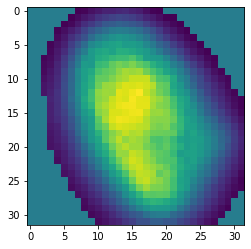

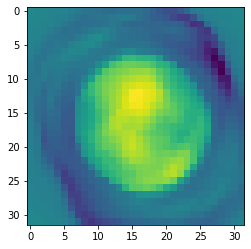

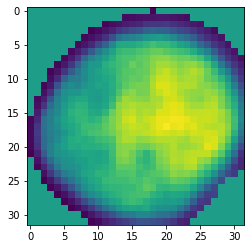

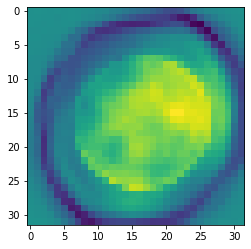

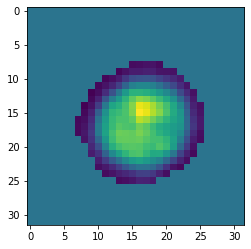

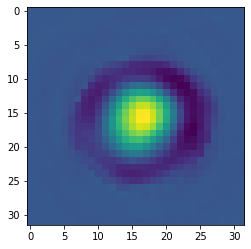

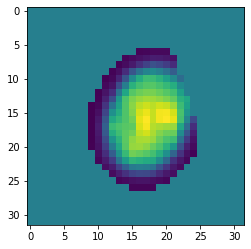

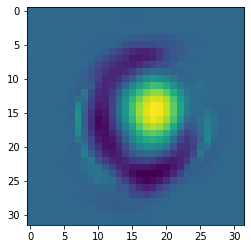

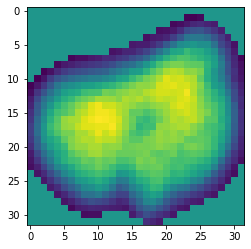

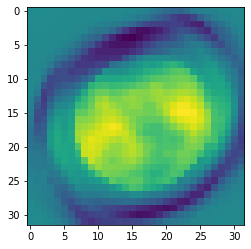

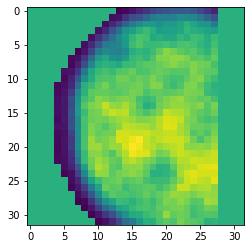

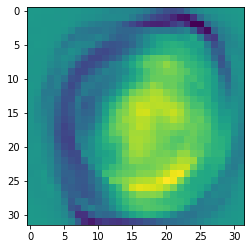

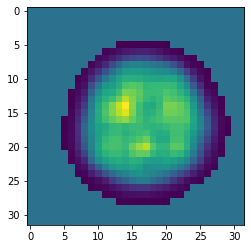

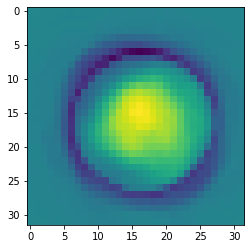

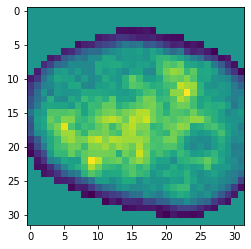

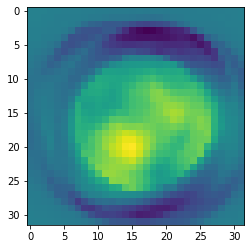

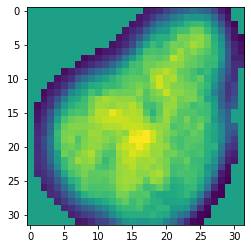

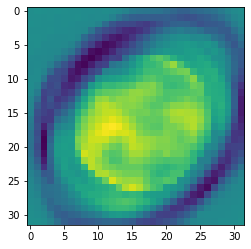

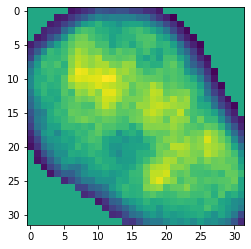

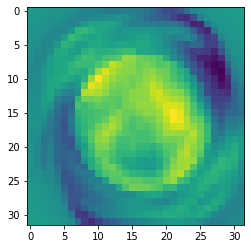

In [69]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE4(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [70]:
encoder4 = vae4.encoder_z()

In [71]:
embeddings_df4 = get_embeddings_df(train_appearances, encoder4, 64, train_real_dict)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [72]:
%%time
embeddings_tsne_df4 = project_embeddings_tsne(embeddings_df4, tsne)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 3h 17min 48s, sys: 5.26 s, total: 3h 17min 53s
Wall time: 20min 8s


In [73]:
vae5 = VAE_MNIST(2048, 1, 1e-3)
AE5 = vae5.build_vae_keras_model()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


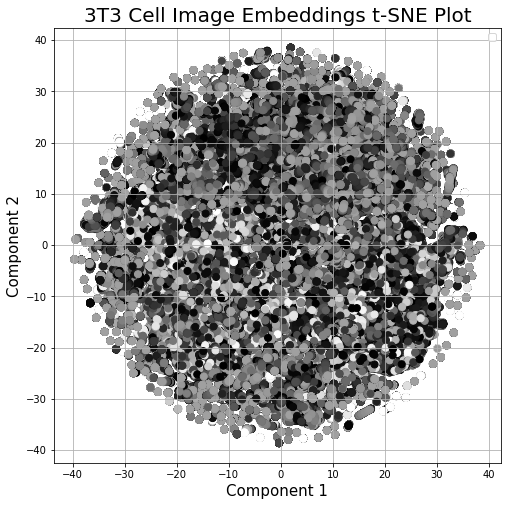

In [76]:
import matplotlib.pyplot as plt

colors = []
for time in embeddings_tsne_df4['Frame']:
    colors.append((time / 70, time / 70, time / 70))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component 1', fontsize = 15)
ax.set_ylabel('Component 2', fontsize = 15)
ax.set_title('3T3 Cell Image Embeddings t-SNE Plot', fontsize = 20)
ax.scatter(embeddings_tsne_df4['component 1'], embeddings_tsne_df4['component 2'], c = colors, s = 50)
ax.legend()
ax.grid()

In [77]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 15
model_path = '../models/dim_2048_reg_10'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE4.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/15
3338/3339 [============================>.] - ETA: 0s - loss: -1965.9777
Epoch 1: val_loss improved from inf to -2103.18701, saving model to ../models/dim_2048_reg_10
3339/3339 [==============================] - 39s 12ms/step - loss: -1965.7662 - val_loss: -2103.1870 - lr: 0.0010
Epoch 2/15
3339/3339 [==============================] - ETA: 0s - loss: -1941.0914
Epoch 2: val_loss did not improve from -2103.18701
3339/3339 [==============================] - 38s 11ms/step - loss: -1941.0914 - val_loss: -1921.2634 - lr: 0.0010
Epoch 3/15
3339/3339 [==============================] - ETA: 0s - loss: -1625.8967
Epoch 3: val_loss did not improve from -2103.18701
3339/3339 [==============================] - 39s 12ms/step - loss: -1625.8967 - val_loss: -1721.8369 - lr: 0.0010
Epoch 4/15
3336/3339 [============================>.] - ETA: 0s - loss: -1907.7426
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_loss did not improve from -2103.18701
33

In [1]:
vae5 = VAE_MNIST(2048, 1, 1e-3)
AE5 = vae5.build_vae_keras_model()
AE5.load_weights('../models/dim_2048_reg_10')

NameError: name 'VAE_MNIST' is not defined

In [78]:
encoder5 = vae5.encoder_z()

In [ ]:
embeddings_df5 = get_embeddings_df(train_appearances, encoder5, 2048, train_real_dict)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [ ]:
%%time
embeddings_tsne_df5 = project_embeddings_tsne(embeddings_df5, tsne)

# Model loading works (deterministic model)

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [21]:
class VAE_DET:
    
    def __init__(self, dim_z, learning_rate):
        # change dim from (28, 28, 1)
        self.dim_x = (32, 32, 1)
        self.dim_z = dim_z
#         self.kl_weight = kl_weight
        self.learning_rate = learning_rate

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        layers.append(tfkl.Conv2D(filters=32, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Conv2D(filters=64, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfkl.Dense(self.dim_z, 
                                 activation=None, name='fake_z_sample'))
#         layers.append(tfpl.IndependentNormal(self.dim_z, 
#             convert_to_tensor_fn=tfd.Distribution.sample, 
#             activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
#             name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        layers.append(tfkl.Dense(8*8*32, activation=None))
        layers.append(tfkl.Reshape((8,8,32)))
        layers.append(tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [22]:
vae_det = VAE_DET(1024, 1e-3)
AE_DET = vae_det.build_vae_keras_model()

2022-07-26 21:53:50.774501: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [26]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3339
validation_steps = 784
n_epochs = 10
model_path = '../models/det_model'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE_DET.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/10


2022-07-26 22:16:28.003408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3337/3339 [============================>.] - ETA: 0s - loss: -567.1157
Epoch 1: val_loss improved from inf to -832.17224, saving model to ../models/det_model
3339/3339 [==============================] - 98s 27ms/step - loss: -567.2304 - val_loss: -832.1722 - lr: 0.0010
Epoch 2/10
3334/3339 [============================>.] - ETA: 0s - loss: -1159.8219
Epoch 2: val_loss improved from -832.17224 to -1139.25891, saving model to ../models/det_model
3339/3339 [==============================] - 42s 13ms/step - loss: -1159.3665 - val_loss: -1139.2589 - lr: 0.0010
Epoch 3/10
3339/3339 [==============================] - ETA: 0s - loss: -1205.1925
Epoch 3: val_loss improved from -1139.25891 to -1268.65393, saving model to ../models/det_model
3339/3339 [==============================] - 39s 12ms/step - loss: -1205.1925 - val_loss: -1268.6539 - lr: 0.0010
Epoch 4/10
3334/3339 [============================>.] - ETA: 0s - loss: -1139.3342
Epoch 4: val_loss did not improve from -1268.65393
3339/3339 [

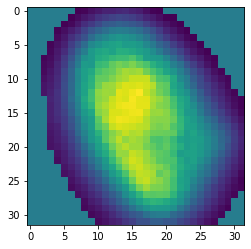

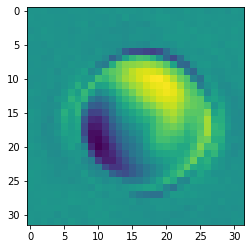

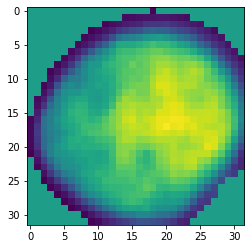

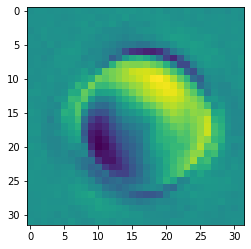

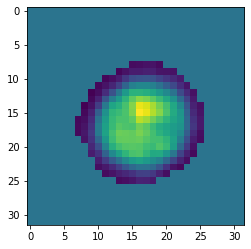

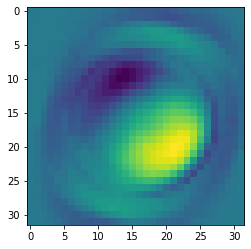

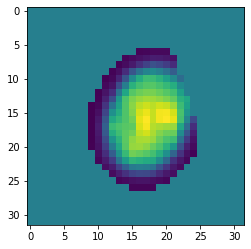

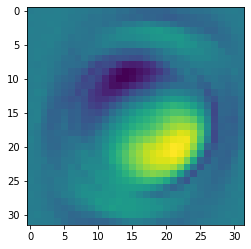

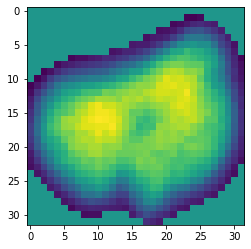

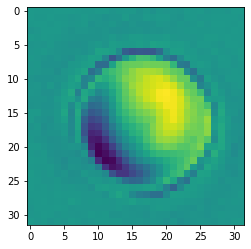

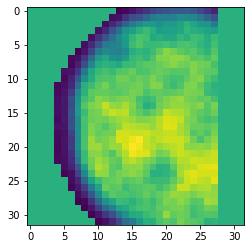

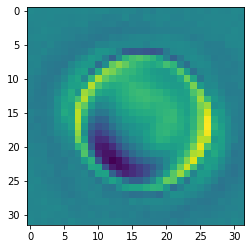

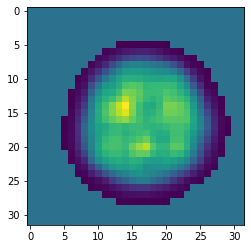

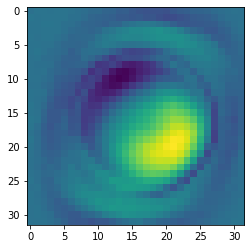

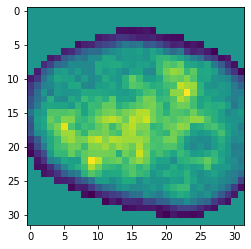

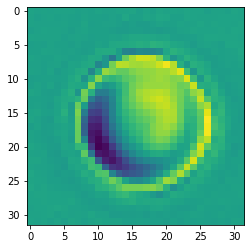

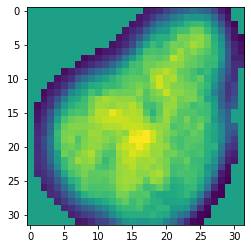

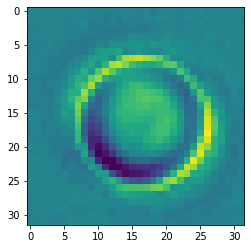

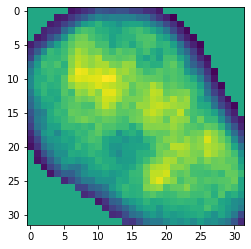

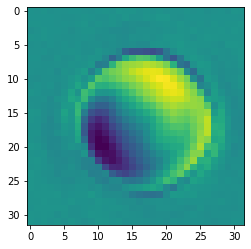

In [27]:
recon_sample = [263403, 234088, 108714, 100465, 187225, 196221, 132592, 287101, 271923, 184110]

import matplotlib.pyplot as plt

for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE_DET(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])

In [28]:
vae_det2 = VAE_DET(1024, 1e-3)
AE_DET2 = vae_det2.build_vae_keras_model()
AE_DET2.load_weights('../models/det_model')

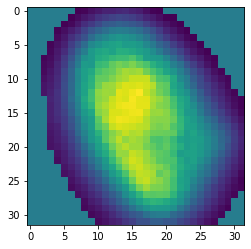

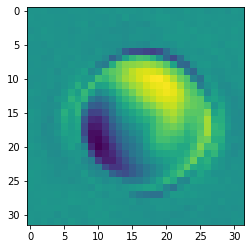

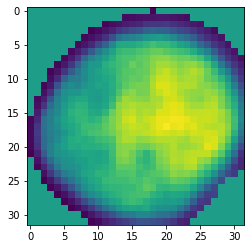

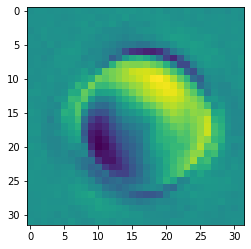

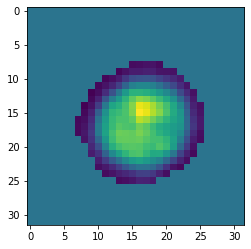

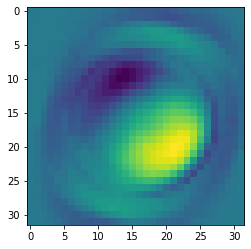

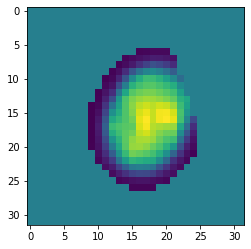

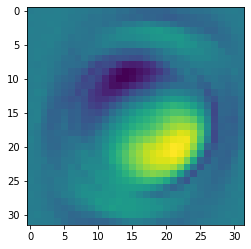

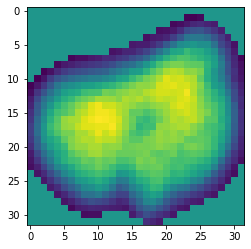

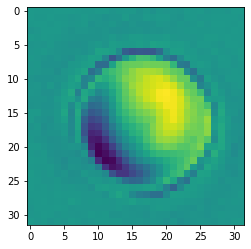

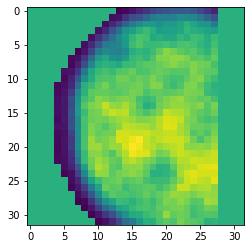

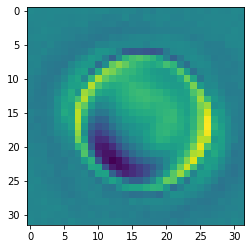

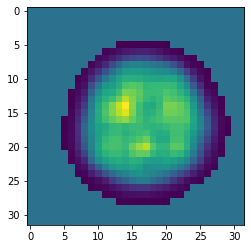

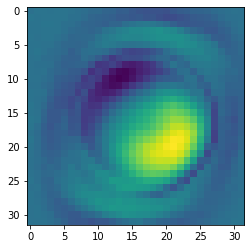

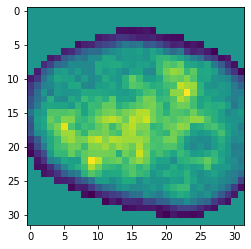

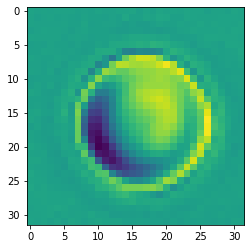

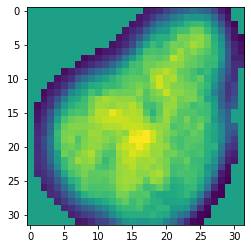

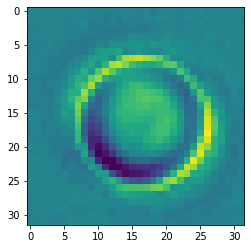

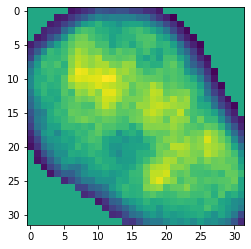

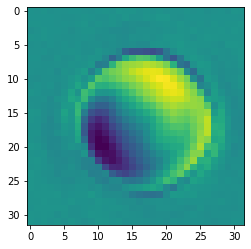

In [29]:
for idx in recon_sample:
    x = np.array([train_appearances[idx]])
    xhat = AE_DET2(x).mean()

    fig, ax = plt.subplots()
    ax.imshow(x[0])

    fig, ax = plt.subplots()
    ax.imshow(xhat[0])